<a href="https://colab.research.google.com/github/tynguyen/ML_ipython_worksheets/blob/main/K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 520: Machine Learning, Fall 2020**
# **Week 2, Worksheet 1**
## **K Nearest Neighbors (KNN)** 


- **Content Creator:** Pooja Consul
- **Content Reviewers:** Tejas Srivastava, Michael Zhou

The objective of this notebook is to walk through a working example of the K Nearest Neighbors (KNN) classification algorithm for the task of 
handwritten digit classification. The handwritten digits denote number 0-9. We will be using the famous MNIST dataset here. 



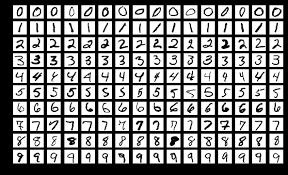

##Import Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Dataset

We will start by loading the MNIST dataset from sklearn and then create training, validation, and testing data.


In [ ]:
# load the MNIST digits dataset
mnist = datasets.load_digits()

# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing

(X_train, X_test, y_train, y_test) = train_test_split(np.array(mnist.data),
mnist.target, test_size=0.25, random_state=42)

# now, let's take 10% of the training data and use that for validation

(X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# show the sizes of each data split

print("training data points: {}".format(len(y_train)))
print("validation data points: {}".format(len(y_val)))
print("testing data points: {}".format(len(y_test)))


training data points: 1212
validation data points: 135
testing data points: 450


##Training

We will use sklearn's KNeighborsClassifier for training. Let us use different values of 'k' to gain some insights.

In [ ]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
k_values = range(1, 30, 2)
accuracies = []

# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in range(1, 30, 2):
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  score = model.score(X_val, y_val)
  accuracies.append(score)
          

##Evaluation

Finally, we will plot how different k values fare.

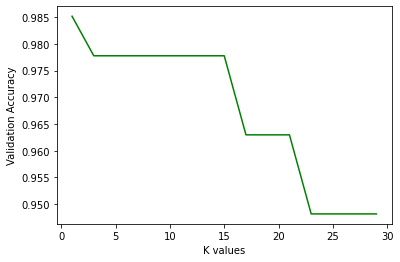

In [ ]:
plt.plot(k_values, accuracies, color='g')
plt.xlabel("K values")
plt.ylabel("Validation Accuracy")
plt.show()

- Can you explain the trend in the plot? 

- What do you think happens when k=1 or when k takes larger values? Why do these trends occur?

- Which optimal value of k should be chosen?

Retraining with our chosen value of k, we can reevaluate the selected classifier. 

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        38
           3       1.00      0.98      0.99        46
           4       0.98      1.00      0.99        55
           5       0.98      0.93      0.96        59
           6       0.98      1.00      0.99        45
           7       1.00      1.00      1.00        41
           8       0.97      0.95      0.96        38
           9       0.94      0.96      0.95        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Predicted digit :  1


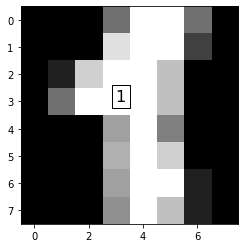

Predicted digit :  5


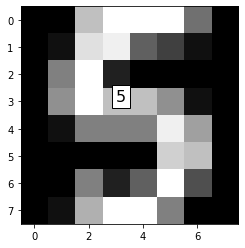

Predicted digit :  5


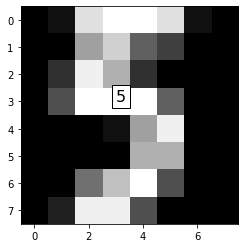

Predicted digit :  0


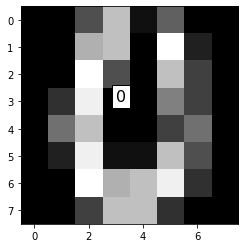

Predicted digit :  1


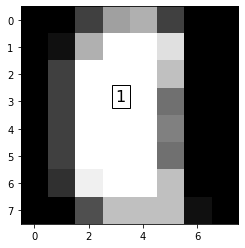

In [ ]:
# re-train our classifier using  k = 5 and predict the labels of the test data
k = 5
model = KNeighborsClassifier(n_neighbors=k_values[k])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits

print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions))

# displaying results for a few digits
for i in np.random.randint(0, high=len(y_test), size=(5,)):
  # grab the image and classify it
  image = X_test[i]
  prediction = model.predict([image])[0]
  
  # show the prediction
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((8,8))
  plt.imshow(pixels,cmap='gray')
  plt.annotate(prediction,(3,3),bbox={'facecolor':'white'},fontsize=16)
  print("Predicted digit : ",prediction)
  plt.show()